In [29]:
import torch
import torchvision.models as models
from torchvision import models,datasets,transforms
import os
import shutil
import pandas as pd
import torch.nn as nn
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Import TrashNet data

In [16]:
dir = '../data/dataset-resized'

params = { 'batch_size':16,
           'shuffle':True,
           'num_workers':4 }

transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(256),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_dataset = datasets.ImageFolder(root=dir,transform = transform)

test_dataloader = torch.utils.data.DataLoader(test_dataset, **params)

class_names = test_dataset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Import RealWaste data

In [30]:
dir = '../data/realwaste-main'

params = { 'batch_size':16,
           'shuffle':True,
           'num_workers':4 }

transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(256),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_dataset = datasets.ImageFolder(os.path.join(dir, 'RealWaste'),transform = transform)

test_dataloader = torch.utils.data.DataLoader(test_dataset, **params)

class_names = test_dataset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Testing procedure

In [31]:
# Load the model architecture (must match the one used in training)
model = models.densenet121(pretrained=False)  # Or use the same architecture you used
num_classes = 6 # Ensure this matches the number of classes in your training dataset
model.classifier = torch.nn.Linear(model.classifier.in_features, num_classes)

# Load the pre-trained model weights
model_path = "saved_models/trained_trashnet_densenet.pth"
model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode
model.eval()

/opt/miniconda3/envs/mlp/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/miniconda3/envs/mlp/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/var/folders/bn/9jpk7_vs2wz__6f0k16kkrdw0000gn/T/ipykernel_99867/2863543666.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default va

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [32]:
y_true = []  # True labels
y_pred = []  # Predicted labels

with torch.no_grad():  # Disable gradient computation for evaluation
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get class with highest probability

        # Store results
        y_true.extend(labels.cpu().numpy())   # Convert to numpy for evaluation
        y_pred.extend(predicted.cpu().numpy())

# Convert to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [33]:
# Get class-wise accuracy
class_correct = np.zeros(num_classes)
class_total = np.zeros(num_classes)

for i in range(len(y_true)):
    label = y_true[i]
    if y_true[i] == y_pred[i]:
        class_correct[label] += 1
    class_total[label] += 1

# Print class-wise accuracy
for i in range(num_classes):
    if class_total[i] > 0:  # Avoid division by zero
        print(f'Accuracy of class {class_names[i]}: {100 * class_correct[i] / class_total[i]:.2f}%')


IndexError: index 6 is out of bounds for axis 0 with size 6

Classification Report:
                      precision    recall  f1-score   support

          Cardboard       0.29      0.35      0.31       461
      Food Organics       0.06      0.05      0.05       411
              Glass       0.05      0.18      0.08       420
              Metal       0.03      0.04      0.04       790
Miscellaneous Trash       0.06      0.17      0.09       495
              Paper       0.35      0.06      0.11       500
            Plastic       0.00      0.00      0.00       921
      Textile Trash       0.00      0.00      0.00       318
         Vegetation       0.00      0.00      0.00       436

           accuracy                           0.08      4752
          macro avg       0.09      0.09      0.08      4752
       weighted avg       0.09      0.08      0.07      4752



/opt/miniconda3/envs/mlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/mlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/mlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(0.5, 1.0, 'Confusion Matrix Heatmap')

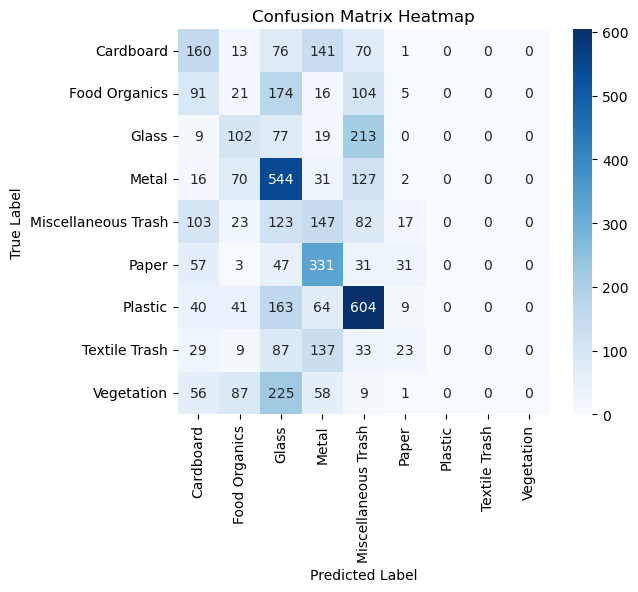

In [34]:
# Generate classification report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Create a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)

# Labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")

In [9]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

KeyboardInterrupt: 